# 1. Import thư viện #

In [468]:

import pandas as pd #đọc dữ liệu
import numpy as np #xử lý dữ liệu
import matplotlib.pyplot as plt #vẽ biểu đồ
from sklearn.preprocessing import MinMaxScaler #chuẩn hóa dữ liệu
from keras.callbacks import ModelCheckpoint #lưu lại huấn luyện tốt nhất
from tensorflow.keras.models import load_model #tải mô hình

#các lớp để xây dựng mô hình
from keras.models import Sequential #đầu vào
from keras.layers import LSTM #học phụ thuộc
from keras.layers import Dropout #tránh học tủ
from keras.layers import Dense #đầu ra

#kiểm tra độ chính xác của mô hình
from sklearn.metrics import r2_score #đo mức độ phù hợp
from sklearn.metrics import mean_absolute_error #đo sai số tuyệt đối trung bình
from sklearn.metrics import mean_absolute_percentage_error #đo % sai số tuyệt đối trung bình

# 2. Đọc file #

In [469]:
df = pd.read_csv("D:\TÀI LIỆU HỌC TẬP\Đề Tài Tốt Nghiệp\Dữ liệu Lịch sử Vinamilk.csv")

# 3. Mô tả bộ dữ liệu 

In [470]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501 entries, 0 to 500
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Ngày        501 non-null    object
 1   Lần cuối    501 non-null    object
 2   Mở          501 non-null    object
 3   Cao         501 non-null    object
 4   Thấp        501 non-null    object
 5   KL          501 non-null    object
 6   % Thay đổi  501 non-null    object
dtypes: object(7)
memory usage: 27.5+ KB


In [471]:
df.describe()

,Ngày,Lần cuối,Mở,Cao,Thấp,KL,% Thay đổi
count,501,501,501,501,501,501,501
unique,501,296,306,318,285,324,264
top,20/06/2024,"67,000.0","71,149.9","67,300.0","70,580.7",2.60M,0.00%
freq,1,7,7,8,8,7,35


In [472]:
df.info

<bound method DataFrame.info of            Ngày  Lần cuối        Mở       Cao      Thấp       KL % Thay đổi
0    20/06/2024  65,900.0  65,100.0  66,100.0  65,100.0  905.40K      0.92%
1    19/06/2024  65,300.0  66,000.0  66,000.0  65,100.0    6.16M     -0.91%
2    18/06/2024  65,900.0  66,500.0  66,500.0  65,900.0    2.75M     -0.15%
3    17/06/2024  66,000.0  66,300.0  66,600.0  66,000.0    3.62M     -0.30%
4    14/06/2024  66,200.0  67,000.0  67,300.0  66,200.0    4.12M     -1.05%
..          ...       ...       ...       ...       ...      ...        ...
496  24/06/2022  64,422.4  63,971.9  65,683.9  63,881.8    1.68M      1.13%
497  23/06/2022  63,701.6  63,611.5  64,872.9  63,070.9    1.10M      0.14%
498  22/06/2022  63,611.5  65,864.1  66,134.4  63,611.5    2.21M     -4.21%
499  21/06/2022  66,404.7  62,350.1  66,494.8  61,989.7    4.84M      6.81%
500  20/06/2022  62,169.9  59,827.3  62,800.6  59,827.3    2.59M      3.45%

[501 rows x 7 columns]>

In [473]:
df.head(10)

,Ngày,Lần cuối,Mở,Cao,Thấp,KL,% Thay đổi
0,20/06/2024,"65,900.0","65,100.0","66,100.0","65,100.0",905.40K,0.92%
1,19/06/2024,"65,300.0","66,000.0","66,000.0","65,100.0",6.16M,-0.91%
2,18/06/2024,"65,900.0","66,500.0","66,500.0","65,900.0",2.75M,-0.15%
3,17/06/2024,"66,000.0","66,300.0","66,600.0","66,000.0",3.62M,-0.30%
4,14/06/2024,"66,200.0","67,000.0","67,300.0","66,200.0",4.12M,-1.05%
5,13/06/2024,"66,900.0","67,000.0","67,400.0","66,800.0",2.80M,-0.15%
6,12/06/2024,"67,000.0","66,500.0","67,300.0","66,300.0",3.43M,0.75%
7,11/06/2024,"66,500.0","67,400.0","67,500.0","66,400.0",6.18M,-1.04%
8,10/06/2024,"67,200.0","68,400.0","68,500.0","67,200.0",4.56M,-0.88%
9,07/06/2024,"67,800.0","67,600.0","68,600.0","67,500.0",4.13M,0.89%


# 4. Tiền xử lý dữ liệu


In [474]:
# Chuyển đổi cột 'Ngày' sang kiểu datetime
df['Ngày'] = pd.to_datetime(df['Ngày'], format='%d/%m/%Y')

# Sắp xếp lại dữ liệu theo thứ tự thời gian
df = df.sort_values(by='Ngày')

# Loại bỏ dấu phẩy và chuyển đổi các cột số sang kiểu float
df['Lần cuối'] = df['Lần cuối'].str.replace(',', '').astype(float)
df['Mở'] = df['Mở'].str.replace(',', '').astype(float)
df['Cao'] = df['Cao'].str.replace(',', '').astype(float)
df['Thấp'] = df['Thấp'].str.replace(',', '').astype(float)

In [475]:
# Chuyển đổi khối lượng giao dịch từ dạng chuỗi có hậu tố sang số nguyên
def convert_volume(volume):
    if 'K' in volume:
        return int(float(volume.replace('K', '')) * 1000)
    elif 'M' in volume:
        return int(float(volume.replace('M', '')) * 1000000)
    else:
        return int(volume)

df['KL'] = df['KL'].apply(convert_volume)

# Chuyển đổi phần trăm thay đổi từ dạng chuỗi sang số thực
df['% Thay đổi'] = df['% Thay đổi'].str.replace('%', '').astype(float)

# Kiểm tra lại kiểu dữ liệu
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 501 entries, 500 to 0
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Ngày        501 non-null    datetime64[ns]
 1   Lần cuối    501 non-null    float64       
 2   Mở          501 non-null    float64       
 3   Cao         501 non-null    float64       
 4   Thấp        501 non-null    float64       
 5   KL          501 non-null    int64         
 6   % Thay đổi  501 non-null    float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 31.3 KB


In [476]:
df.head(10)

,Ngày,Lần cuối,Mở,Cao,Thấp,KL,% Thay đổi
500,2022-06-20,62169.9,59827.3,62800.6,59827.3,2590000,3.45
499,2022-06-21,66404.7,62350.1,66494.8,61989.7,4840000,6.81
498,2022-06-22,63611.5,65864.1,66134.4,63611.5,2210000,-4.21
497,2022-06-23,63701.6,63611.5,64872.9,63070.9,1100000,0.14
496,2022-06-24,64422.4,63971.9,65683.9,63881.8,1680000,1.13
495,2022-06-27,64062.0,64692.7,64963.0,63341.2,1800000,-0.56
494,2022-06-28,63791.7,63611.5,65503.6,63161.0,3040000,-0.42
493,2022-06-29,65143.2,63611.5,65503.6,63611.5,1940000,2.12
492,2022-06-30,65053.1,65143.2,67395.8,65053.1,3580000,-0.14
491,2022-07-01,66404.7,65143.2,66584.9,64872.9,2860000,2.08


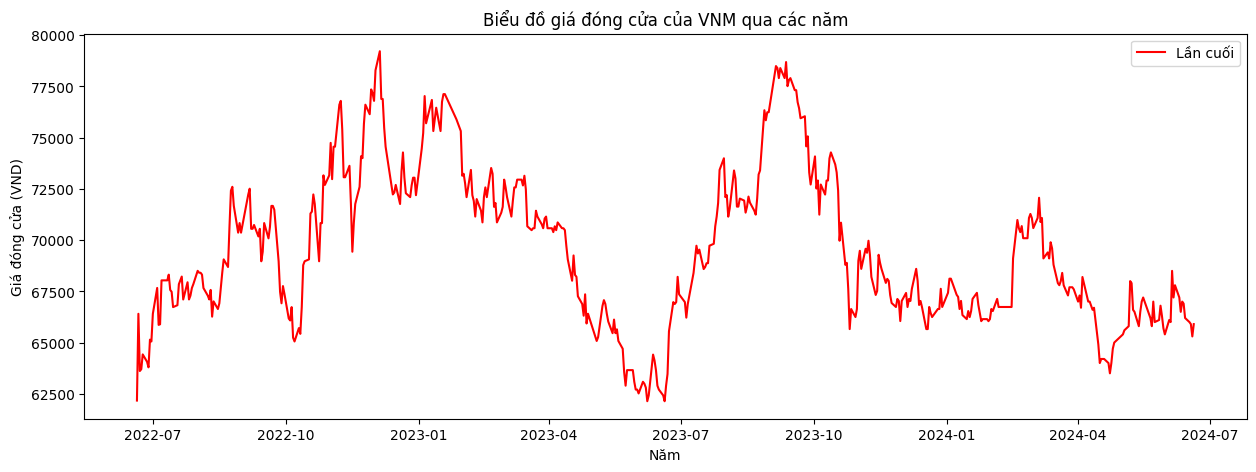

In [477]:
# Biểu đồ giá cổ phiếu từ 20/6/2022 - 20/6/2024
plt.figure(figsize=(15,5))
plt.plot(df['Ngày'],df['Lần cuối'],label='Lần cuối',color='red')
plt.xlabel('Năm')
plt.ylabel('Giá đóng cửa (VND)')
plt.title('Biểu đồ giá đóng cửa của VNM qua các năm')
plt.legend(loc='best')


# 5. Phân chia dữ liệu

In [478]:
df1_full = pd.DataFrame(df,columns=['Ngày','Lần cuối'])
df1_full.index = df1_full.Ngày
df1_full.drop('Ngày',axis=1,inplace=True)
df1_full.info

<bound method DataFrame.info of             Lần cuối
Ngày                
2022-06-20   62169.9
2022-06-21   66404.7
2022-06-22   63611.5
2022-06-23   63701.6
2022-06-24   64422.4
...              ...
2024-06-14   66200.0
2024-06-17   66000.0
2024-06-18   65900.0
2024-06-19   65300.0
2024-06-20   65900.0

[501 rows x 1 columns]>

In [479]:
start_index = int(0.75 * len(df1_full))

# Trích xuất phần tử từ chỉ số đã tính
df1 = df1_full[:start_index]

# In kết quả để kiểm tra
print(df1)

            Lần cuối
Ngày                
2022-06-20   62169.9
2022-06-21   66404.7
2022-06-22   63611.5
2022-06-23   63701.6
2022-06-24   64422.4
...              ...
2023-12-07   67030.3
2023-12-08   67618.3
2023-12-11   68598.2
2023-12-12   68010.3
2023-12-13   66834.3

[375 rows x 1 columns]


In [480]:
df1

,Lần cuối
Ngày,
2022-06-20,62169.9
2022-06-21,66404.7
2022-06-22,63611.5
2022-06-23,63701.6
2022-06-24,64422.4
...,...
2023-12-07,67030.3
2023-12-08,67618.3
2023-12-11,68598.2


In [481]:
data = df1.values
train_data = data[:300]
test_data = data[300:]


In [482]:
# Chuẩn hóa dữ liệu
sc = MinMaxScaler(feature_range=(0, 1))
sc_train = sc.fit_transform(data)

In [483]:
a = 50

In [484]:
#tạo vòng lặp các giá trị
x_train,y_train=[],[]
for i in range(a,len(train_data)):
  x_train.append(sc_train[i-a:i,0]) #lấy 50 giá đóng cửa liên tục
  y_train.append(sc_train[i,0]) #lấy ra giá đóng cửa ngày hôm sau

In [485]:
#xếp dữ liệu thành 1 mảng 2 chiều
x_train = np.array(x_train)
y_train = np.array(y_train)

#xếp lại dữ liệu thành mảng 1 chiều
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
y_train = np.reshape(y_train,(y_train.shape[0],1))

# 6. Xây dựng mô hình

In [486]:

#xây dựng mô hình
model = Sequential() #tạo lớp mạng cho dữ liệu đầu vào
#2 lớp LSTM
model.add(LSTM(units=128,input_shape=(x_train.shape[1],1),return_sequences=True))
model.add(LSTM(units=64))
model.add(Dropout(0.5)) #loại bỏ 1 số đơn vị tránh học tủ (overfitting)
model.add(Dense(1)) #output đầu ra 1 chiều
#đo sai số tuyệt đối trung bình có sử dụng trình tối ưu hóa adam
model.compile(loss='mean_absolute_error',optimizer='adam')

c:\Users\viett\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [487]:
#huấn luyện mô hình
save_model = "D:\TÀI LIỆU HỌC TẬP\Đề Tài Tốt Nghiệp\save_model.keras"
best_model = ModelCheckpoint(save_model,monitor='loss',verbose=2,save_best_only=True,mode='auto')
model.fit(x_train,y_train,epochs=100,batch_size=a,verbose=2,callbacks=[best_model])

Epoch 1/100

Epoch 1: loss improved from inf to 0.30547, saving model to D:\TÀI LIỆU HỌC TẬP\Đề Tài Tốt Nghiệp\save_model.keras
5/5 - 4s - 854ms/step - loss: 0.3055
Epoch 2/100

Epoch 2: loss improved from 0.30547 to 0.16597, saving model to D:\TÀI LIỆU HỌC TẬP\Đề Tài Tốt Nghiệp\save_model.keras
5/5 - 0s - 69ms/step - loss: 0.1660
Epoch 3/100

Epoch 3: loss improved from 0.16597 to 0.14729, saving model to D:\TÀI LIỆU HỌC TẬP\Đề Tài Tốt Nghiệp\save_model.keras
5/5 - 0s - 71ms/step - loss: 0.1473
Epoch 4/100

Epoch 4: loss improved from 0.14729 to 0.13016, saving model to D:\TÀI LIỆU HỌC TẬP\Đề Tài Tốt Nghiệp\save_model.keras
5/5 - 1s - 106ms/step - loss: 0.1302
Epoch 5/100

Epoch 5: loss improved from 0.13016 to 0.12427, saving model to D:\TÀI LIỆU HỌC TẬP\Đề Tài Tốt Nghiệp\save_model.keras
5/5 - 0s - 73ms/step - loss: 0.1243
Epoch 6/100

Epoch 6: loss improved from 0.12427 to 0.11688, saving model to D:\TÀI LIỆU HỌC TẬP\Đề Tài Tốt Nghiệp\save_model.keras
5/5 - 0s - 62ms/step - loss: 0

In [488]:
#dữ liệu train
y_train = sc.inverse_transform(y_train) #giá thực
final_model = load_model("D:\TÀI LIỆU HỌC TẬP\Đề Tài Tốt Nghiệp\save_model.keras")
y_train_predict = final_model.predict(x_train) #dự đoán giá đóng cửa trên tập đã train
y_train_predict = sc.inverse_transform(y_train_predict) #giá dự đoán

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step


In [489]:
#xử lý dữ liệu test
test = df1[len(train_data)-a:].values
test = test.reshape(-1,1)
sc_test = sc.transform(test)

x_test = []
for i in range(a,test.shape[0]):
  x_test.append(sc_test[i-a:i,0])
x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

#dữ liệu test
y_test = data[300:] #giá thực
y_test_predict = final_model.predict(x_test)
y_test_predict = sc.inverse_transform(y_test_predict) #giá dự đoán

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


# 7. Đánh giá độ chính xác của mô hình

C:\Users\viett\AppData\Local\Temp\ipykernel_16836\2971483345.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data1['Dự đoán'] = y_train_predict #thêm dữ liệu
C:\Users\viett\AppData\Local\Temp\ipykernel_16836\2971483345.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data1['Dự đoán'] = y_test_predict #thêm dữ liệu


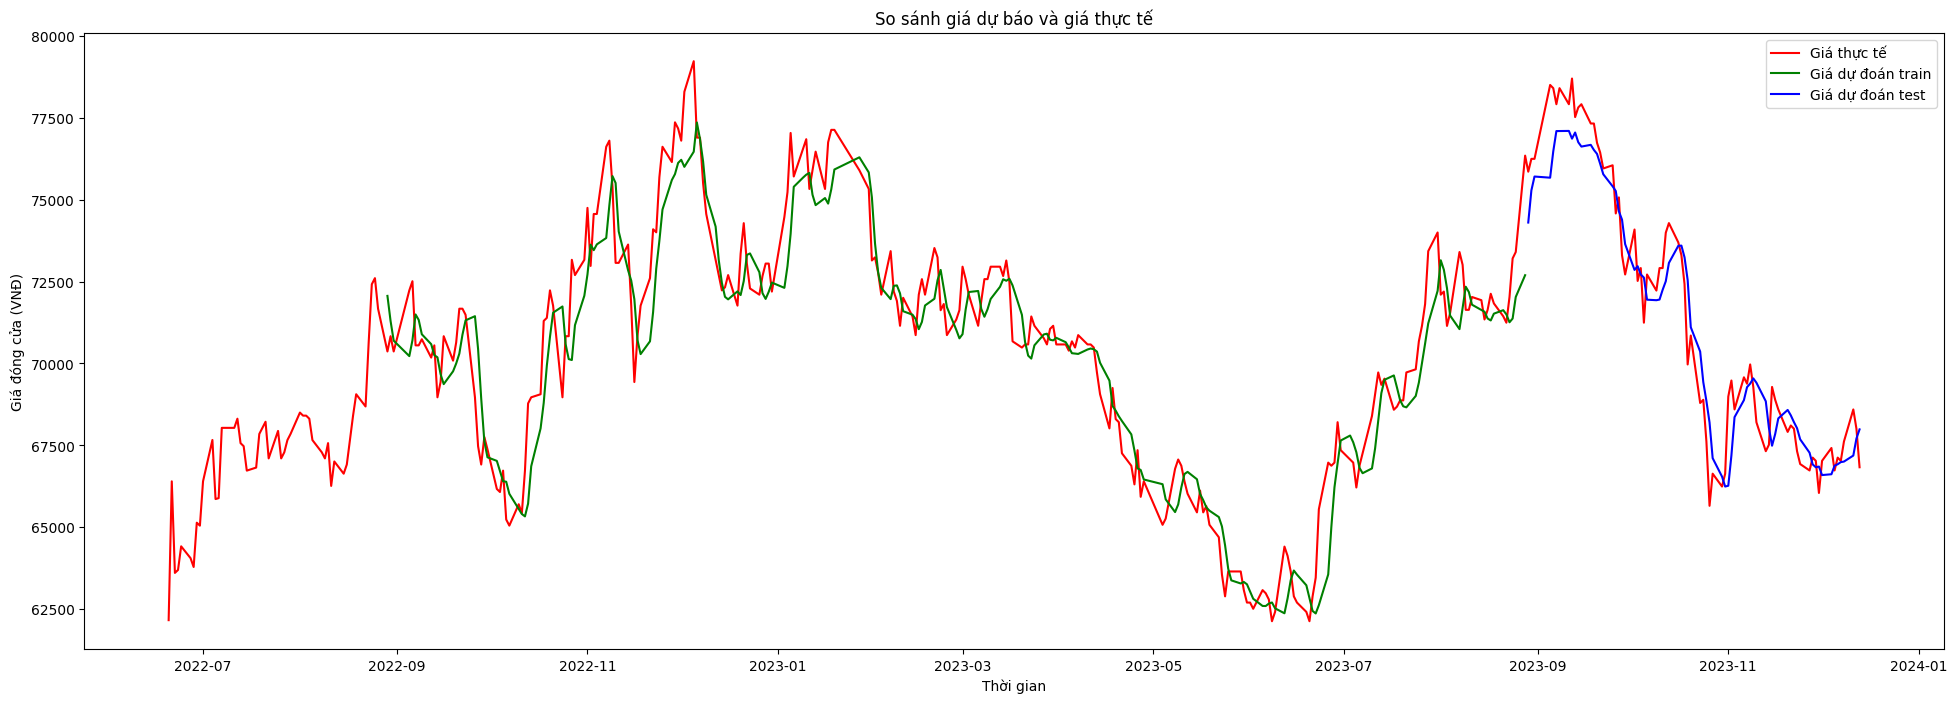

In [490]:
#lập biểu đồ so sánh
train_data1 = df1[a:300]
test_data1 = df1[300:]

plt.figure(figsize=(24,8))
plt.plot(df1,label='Giá thực tế',color='red') #đường giá thực
train_data1['Dự đoán'] = y_train_predict #thêm dữ liệu
plt.plot(train_data1['Dự đoán'],label='Giá dự đoán train',color='green') #đường giá dự báo train
test_data1['Dự đoán'] = y_test_predict #thêm dữ liệu
plt.plot(test_data1['Dự đoán'],label='Giá dự đoán test',color='blue') #đường giá dự báo test
plt.title('So sánh giá dự báo và giá thực tế') #đặt tên biểu đồ
plt.xlabel('Thời gian') #đặt tên hàm x
plt.ylabel('Giá đóng cửa (VNĐ)') #đặt tên hàm y
plt.legend() #chú thích
plt.show()

In [491]:
#  ĐÁNH GIÁ ĐỘ PHÙ HỢP, SAI SỐ, ...
print('Độ phù hợp tập train:',r2_score(y_train,y_train_predict))
print('Sai số tuyệt đối trung bình trên tập train (VNĐ):',mean_absolute_error(y_train,y_train_predict))
print('Phần trăm sai số tuyệt đối trung bình tập train:',mean_absolute_percentage_error(y_train,y_train_predict))

Độ phù hợp tập train: 0.9014391002358334
Sai số tuyệt đối trung bình trên tập train (VNĐ): 922.209053125
Phần trăm sai số tuyệt đối trung bình tập train: 0.012996539185848824


In [492]:
print('Độ phù hợp tập test:',r2_score(y_test,y_test_predict))
print('Sai số tuyệt đối trung bình trên tập test (VNĐ):',mean_absolute_error(y_test,y_test_predict))
print('Phần trăm sai số tuyệt đối trung bình tập test:',mean_absolute_percentage_error(y_test,y_test_predict))

Độ phù hợp tập test: 0.9304587706225331
Sai số tuyệt đối trung bình trên tập test (VNĐ): 852.6398333333334
Phần trăm sai số tuyệt đối trung bình tập test: 0.011899317020707139


In [493]:
import datetime

# 8. Dự đoán 6 từ cuối 2023 -> 20/6/2024

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━

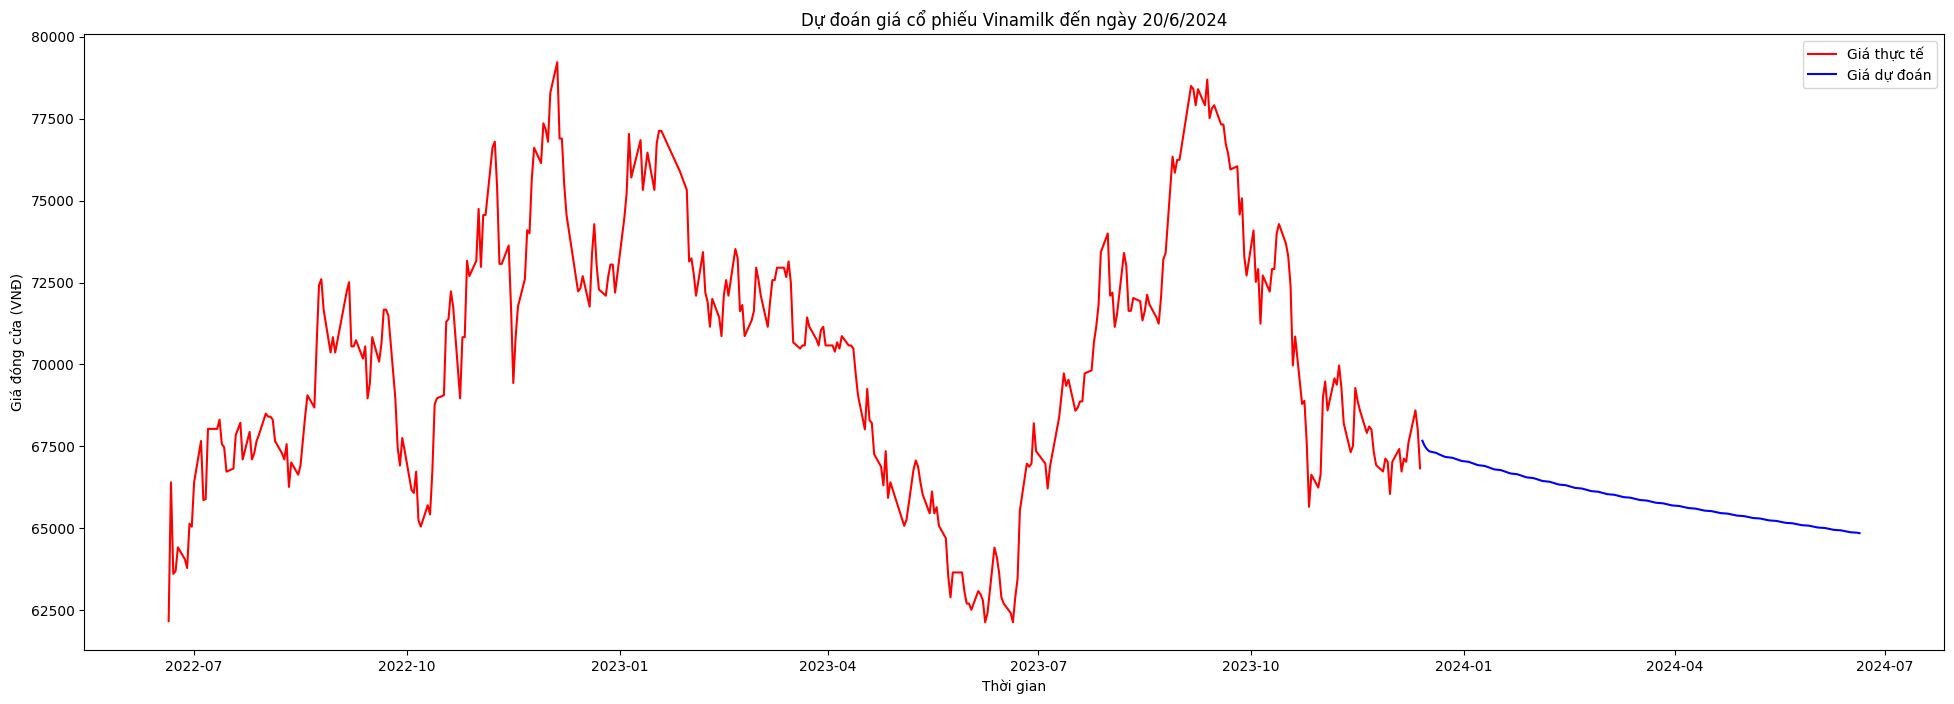

In [496]:
# Nạp mô hình đã huấn luyện
model = load_model("D:\TÀI LIỆU HỌC TẬP\Đề Tài Tốt Nghiệp\save_model.keras")

# Đặt ngày kết thúc dự đoán
end_date = datetime.datetime(2024, 6, 20)

# Lấy ngày cuối cùng trong tập dữ liệu hiện tại
last_date = df1.index[-1]

# Tạo tập dữ liệu cho dự đoán
future_dates = []
predicted_prices = []

# Chuẩn bị dữ liệu dự đoán ban đầu
last_a_days = df1['Lần cuối'].values[-a:]
scaled_last_a_days = sc.transform(last_a_days.reshape(-1, 1))

while last_date < end_date:
    last_date += datetime.timedelta(days=1)
    # Bỏ qua các ngày thứ Hai và thứ Ba
    if last_date.weekday() in [0, 1]:
        continue
    future_dates.append(last_date)

    # Chuẩn bị dữ liệu đầu vào cho mô hình
    x_predict = np.array([scaled_last_a_days])
    x_predict = np.reshape(x_predict, (x_predict.shape[0], x_predict.shape[1], 1))

    # Dự đoán giá
    predicted_price = model.predict(x_predict)
    predicted_prices.append(predicted_price[0, 0])

    # Cập nhật dữ liệu dự đoán
    scaled_last_a_days = np.append(scaled_last_a_days[1:], predicted_price)
    scaled_last_a_days = scaled_last_a_days.reshape(-1, 1)

# Chuyển đổi giá trị dự đoán về dạng ban đầu
predicted_prices = sc.inverse_transform(np.array(predicted_prices).reshape(-1, 1))

# Hiển thị kết quả dự đoán
plt.figure(figsize=(24, 8))
plt.plot(df1.index, df1['Lần cuối'], color='red', label='Giá thực tế')
# plt.plot(df1_full.index, df1_full['Lần cuối'], color='green', label='Giá thực tế')
plt.plot(future_dates, predicted_prices, color='blue', label='Giá dự đoán')
plt.title('Dự đoán giá cổ phiếu Vinamilk đến ngày 20/6/2024')
plt.xlabel('Thời gian')
plt.ylabel('Giá đóng cửa (VNĐ)')
plt.legend()
plt.show()

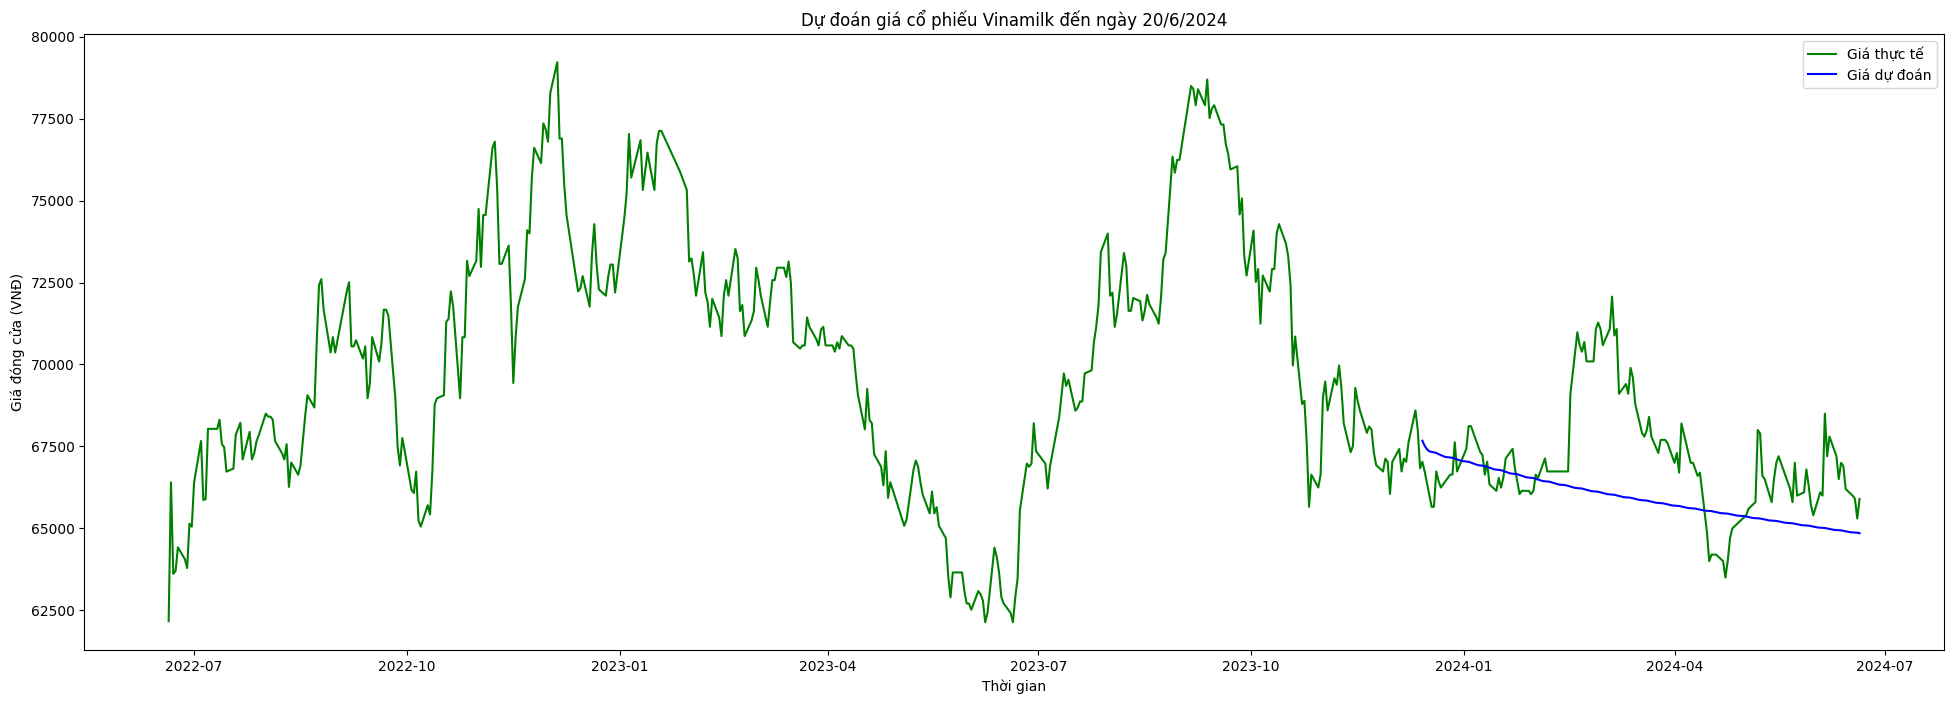

In [495]:
# Hiển thị kết quả dự đoán
plt.figure(figsize=(24, 8))
# plt.plot(df1.index, df1['Lần cuối'], color='red', label='Giá thực tế')
plt.plot(df1_full.index, df1_full['Lần cuối'], color='green', label='Giá thực tế')
plt.plot(future_dates, predicted_prices, color='blue', label='Giá dự đoán')
plt.title('Dự đoán giá cổ phiếu Vinamilk đến ngày 20/6/2024')
plt.xlabel('Thời gian')
plt.ylabel('Giá đóng cửa (VNĐ)')
plt.legend()
plt.show()